In [1]:
import pandas as pd
import dateutil
import datetime
from epiweeks import Week, Year
import numpy as np
import array as arr 
from pandas import ExcelWriter
from pandas import ExcelFile
import glob, os, re
from StyleFrame import StyleFrame, utils
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import matplotlib.ticker as ticker

In [2]:
def sortKeyFunc(s):
    return int(os.path.basename(s)[:-4])
def only_cells_with_hex_background(cell):
        return cell if cell.style.bg_color in {utils.colors.purple, 'FF8080FF'} else np.nan

In [3]:
#change folder (data)
os.chdir("/Users/agmunoz/Documents/Angel/Publics/Guatemala_ClimateNutrition_GonzalezRomeroetal/Data/")
#Indicate how many lines are being used in the Excel file as header:
head=2
shnum=7 #number of Excel sheets to process
years=['2010','2011','2012','2013','2014','2015','2016']

In [4]:
# #Vector indicating the Excel line number with the department data
# linenum= arr.array('i', [21, 30, 45, 62, 77, 91, 101, 109, 129, 150, 159, 188, 220, 240, 258, 266, 279, 285, 297, 309, 317, 331, 347])
# linenum=[x - (head+2) for x in linenum]

In [5]:
# for file in sorted(glob.glob("*.xlsx"), key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
#     print(file)
#     df = pd.read_excel(file, sheet_name=0,header=head)
#     for i in departments:
#         #print(df.iloc[i,0])
#         print(df[df.iloc[:,0].str.match(i)])

In [6]:
# #Vector with name of departments (will be used to find the lines in each Excel file tab):
# departments=["Guatemala", "El Progreso", "Sacatepéquez", "Chimaltenango",\
# "Escuintla","Santa Rosa", "Sololá", "Totonicapán","Quetzaltenango","Suchitepéquez","Retalhuleu","San Marcos",\
# "Huehuetenango","Quiché","Alta Verapaz","Baja Verapaz","Petén","Izabal","Zacapa","Chiquimula","Jalapa","Jutiapa"]

In [7]:
#Only uncomment and run to identify the Hex background color of the cells you want to read (add the cell ID to line 3; e.g.,A21) )
wb = load_workbook('Guatemala_desnutricionaguda.xlsx', data_only=True)
sh = wb['2010']
i=sh['A21'].fill.start_color.index #Add column ID inside sh
print('Hex background color code of the selected cell: '+i)

Hex background color code of the selected cell: FF8080FF


In [8]:
#Read and create array to concatenate all years
j=0 #counter for first worksheet (and year)
sf = StyleFrame.read_excel('Guatemala_desnutricionaguda.xlsx', sheet_name=years[j], read_style=True, use_openpyxl_styles=False)
sf1 = StyleFrame(sf.applymap(only_cells_with_hex_background).dropna(axis=0, how='all').dropna(axis=1, how='all'))
appended_data=sf1.data_df
appended_data=appended_data.set_index(appended_data.columns[0])  #important: we want the department name (column 0) to be used to concatenate new years
date=[]
for week in Year(int(years[j])).iterweeks():
    date.append(week.startdate().strftime('%Y-%m-%d'))
appended_data.columns=date

#Now concatenate
for j in range(1,shnum):
    sfj = StyleFrame.read_excel('Guatemala_desnutricionaguda.xlsx', sheet_name=years[j], read_style=True, use_openpyxl_styles=False)
    sfadd = StyleFrame(sfj.applymap(only_cells_with_hex_background).dropna(axis=0, how='all').dropna(axis=1, how='all'))
    #sfadd.data_df.drop(sfadd.data_df.columns[0],axis=1,inplace=True)
    sfadd.data_df=sfadd.data_df.set_index(sfadd.data_df.columns[0])
    date=[]
    for week in Year(int(years[j])).iterweeks():
        date.append(week.startdate().strftime('%Y-%m-%d'))
    if len(date)>52:  #Guatemala's data has always 52 weeks/year
        date=date[:-1]
    sfadd.data_df.columns=date
    appended_data=pd.concat([appended_data,sfadd.data_df],ignore_index=False,axis=1,sort=False,join='inner')

## Resample epi weeks to monthly resolution (same as the predictors)

In [9]:
#appended_data.T.index.name = "Date"
appended_data=appended_data.T
appended_data.reset_index(level=0, inplace=True)
appended_data

,index,Guatemala,El Progreso,Sacatepéquez,Chimaltenango,Escuintla,Santa Rosa,Sololá,Totonicapán,Quetzaltenango,...,Huehuetenango,Quiché,Alta Verapaz,Baja Verapaz,Petén,Izabal,Zacapa,Chiquimula,Jalapa,Jutiapa
0,2010-01-03,5,3,6,2,0,5,4,14,10,...,8,6,20,1,0,3,11,2,5,3
1,2010-01-10,15.0,2.0,11.0,4.0,2.0,1.0,0.0,1.0,6.0,...,7.0,21.0,11.0,1.0,5.0,4.0,14.0,2.0,5.0,0.0
2,2010-01-17,15.0,3.0,17.0,0.0,7.0,0.0,0.0,4.0,19.0,...,17.0,28.0,22.0,4.0,4.0,10.0,4.0,5.0,7.0,2.0
3,2010-01-24,8.0,3.0,14.0,6.0,7.0,30.0,0.0,0.0,3.0,...,8.0,17.0,34.0,4.0,4.0,9.0,9.0,7.0,7.0,0.0
4,2010-01-31,14.0,3.0,68.0,7.0,6.0,1.0,6.0,3.0,2.0,...,21.0,43.0,29.0,2.0,1.0,12.0,1.0,12.0,10.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2016-11-27,22.0,4.0,5.0,3.0,6.0,4.0,0.0,0.0,7.0,...,12.0,3.0,3.0,0.0,5.0,4.0,0.0,4.0,5.0,0.0
360,2016-12-04,24.0,2.0,6.0,0.0,19.0,5.0,3.0,0.0,7.0,...,8.0,11.0,7.0,0.0,3.0,0.0,2.0,6.0,4.0,0.0
361,2016-12-11,13.0,7.0,0.0,5.0,19.0,13.0,4.0,2.0,1.0,...,11.0,8.0,2.0,0.0,6.0,5.0,1.0,3.0,2.0,0.0
362,2016-12-18,7.0,0.0,45.0,0.0,12.0,6.0,2.0,2.0,2.0,...,5.0,3.0,4.0,0.0,1.0,1.0,4.0,5.0,3.0,1.0


In [10]:
#Let's aggregate by MONTH
#If N months are desired, just change M by NM; e.g., 3M=trimester
appended_data['index']=pd.to_datetime(appended_data['index'],format="%Y-%m-%d")
appended_data['index']=pd.DatetimeIndex(appended_data['index'])
appended_data=appended_data.resample('M',on='index').sum(min_count=1)

In [11]:
undernut=appended_data.astype('float64')
undernut

,Guatemala,El Progreso,Sacatepéquez,Chimaltenango,Escuintla,Santa Rosa,Sololá,Totonicapán,Quetzaltenango,Suchitepéquez,...,Huehuetenango,Quiché,Alta Verapaz,Baja Verapaz,Petén,Izabal,Zacapa,Chiquimula,Jalapa,Jutiapa
index,,,,,,,,,,,,,,,,,,,,,
2010-01-31,57.0,14.0,116.0,19.0,22.0,37.0,10.0,22.0,40.0,62.0,...,61.0,115.0,116.0,12.0,14.0,38.0,39.0,28.0,34.0,7.0
2010-02-28,42.0,28.0,64.0,20.0,37.0,26.0,37.0,13.0,93.0,73.0,...,21.0,95.0,141.0,23.0,18.0,25.0,102.0,105.0,62.0,10.0
2010-03-31,46.0,39.0,28.0,18.0,32.0,20.0,22.0,6.0,30.0,24.0,...,32.0,45.0,107.0,57.0,14.0,21.0,66.0,113.0,162.0,59.0
2010-04-30,35.0,45.0,40.0,24.0,70.0,46.0,52.0,40.0,68.0,15.0,...,136.0,115.0,132.0,222.0,12.0,86.0,83.0,123.0,127.0,85.0
2010-05-31,54.0,65.0,87.0,49.0,106.0,72.0,31.0,66.0,163.0,34.0,...,91.0,239.0,118.0,17.0,70.0,113.0,129.0,200.0,236.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-31,146.0,29.0,78.0,22.0,127.0,45.0,7.0,12.0,43.0,24.0,...,85.0,60.0,95.0,0.0,54.0,22.0,19.0,62.0,21.0,23.0
2016-09-30,147.0,15.0,46.0,24.0,136.0,51.0,7.0,7.0,38.0,39.0,...,104.0,54.0,75.0,0.0,66.0,27.0,25.0,38.0,31.0,24.0
2016-10-31,147.0,23.0,61.0,31.0,160.0,47.0,19.0,15.0,51.0,42.0,...,78.0,53.0,77.0,0.0,49.0,34.0,31.0,40.0,22.0,25.0


## Compute Climatologies and viz

Load data

In [12]:
##Entire country
#rain= pd.read_csv('Rainfall_Guatemala_CHIRPS.csv',header=0, encoding = "iso-8859-1", usecols = [0,1],names=['Date','Rainfall'])
#rain['Date']=pd.to_datetime(rain['Date'],format="%b-%y")
#rain

In [13]:
#department rainfall data
rain= pd.read_csv('Guate_dept_CHIRPS.csv',header=0, encoding= 'latin1')
rain['Date']=pd.to_datetime(rain['Date'],format="%b-%y")
rain.set_index(appended_data.index, inplace=True)
rain.drop('Date',1, inplace=True)
rain

,Guatemala,El Progreso,Sacatepquez,Chimaltenango,Escuintla,Santa Rosa,Solol,Totonicapn,Quetzaltenango,Suchitepquez,...,Huehuetenango,Quich,Baja Verapaz,Alta Verapaz,Petn,Izabal,Zacapa,Chiquimula,Jalapa,Jutiapa
index,,,,,,,,,,,,,,,,,,,,,
2010-01-31,3.23635,6.41445,5.18124,3.74630,2.95270,1.73604,6.78991,2.55183,6.44783,4.66385,...,22.2769,22.1277,9.57161,59.2147,73.1586,131.7100,20.8604,7.46812,3.22182,1.95682
2010-02-28,5.02149,8.42470,7.80626,8.98405,6.17152,2.79143,25.35640,8.70149,9.46927,16.87600,...,11.8111,19.1485,9.75795,36.9639,50.8826,54.4333,14.0062,5.93068,5.93491,2.05900
2010-03-31,6.16916,8.68194,10.58200,13.48920,8.82568,4.77997,28.39510,13.02610,19.71440,17.31540,...,17.2555,20.7370,10.29220,28.9365,39.6896,25.2169,11.8408,6.34057,5.16373,4.58348
2010-04-30,83.98640,91.00160,107.28100,95.49320,143.12200,84.76690,124.78200,82.05720,136.94200,169.43100,...,65.4164,92.1008,94.32500,108.9240,90.6930,106.6850,79.3432,84.25430,56.71750,60.83990
2010-05-31,344.41900,236.63900,464.38100,428.63700,648.52400,559.14600,494.68100,302.25700,543.66200,672.48700,...,269.5550,337.8580,252.46200,363.7720,261.4640,315.0060,259.3180,255.49600,245.54500,381.42300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-31,192.51300,168.03900,235.16400,216.30100,265.56500,219.89000,277.06000,150.37000,270.48600,335.74800,...,265.7850,277.7100,182.32200,318.8930,297.4990,274.1770,187.0410,210.98200,166.82200,196.58300
2016-09-30,224.68500,194.59200,282.33700,266.32400,284.84300,284.44600,326.64700,202.15700,368.48000,355.32900,...,271.6430,287.7440,181.16400,312.9820,255.6360,294.1190,241.2520,287.21000,225.09400,274.78300
2016-10-31,118.55200,69.10190,162.36000,136.43700,301.09700,206.55900,171.35600,79.26220,291.08000,305.75500,...,59.2660,64.6155,62.69080,86.1439,119.3280,85.4862,70.2058,79.91620,86.37880,121.71400


In [14]:
climorain=rain.groupby(rain.index.strftime('%m')).mean()
stdrain=rain.groupby(rain.index.strftime('%m')).std()
climorain.index.name='month'
#climorain.rename(index={'01':'J','02':'F','03':'M','04':'A','05':'M','06':'J','07':'J','08':'A','09':'S','10':'O','11':'N','12':'D'},inplace=True)
climorain

,Guatemala,El Progreso,Sacatepquez,Chimaltenango,Escuintla,Santa Rosa,Solol,Totonicapn,Quetzaltenango,Suchitepquez,...,Huehuetenango,Quich,Baja Verapaz,Alta Verapaz,Petn,Izabal,Zacapa,Chiquimula,Jalapa,Jutiapa
month,,,,,,,,,,,,,,,,,,,,,
01,3.869530,9.144393,5.690713,3.521350,3.253800,1.854619,6.167537,2.300281,7.100639,5.022984,...,22.085357,31.088600,14.606387,88.667071,95.548814,112.644043,23.888286,9.100404,4.771520,2.139976
02,5.248831,8.206056,7.898861,6.342939,5.845617,3.395406,15.115481,6.197724,8.160131,12.100110,...,11.871074,18.993143,10.650491,47.359771,53.851343,75.946386,20.005086,7.784991,5.472610,2.462503
03,14.060080,20.108206,21.964857,22.463271,15.257197,8.495257,44.050257,19.014457,34.712529,30.802314,...,21.197500,35.054786,22.759729,70.188871,58.014614,65.220243,26.823557,15.822953,12.927333,7.040949
04,50.372600,52.632429,66.797400,64.850100,98.228471,52.036886,94.132771,54.018671,110.180714,131.930414,...,39.118386,61.943400,57.992314,76.925014,57.463471,57.384086,48.377271,45.460357,34.533286,38.161043
05,171.941043,130.684957,230.110857,216.502714,320.697000,258.994714,273.234857,154.319486,329.957857,387.951286,...,126.290414,163.706986,138.164271,216.610000,170.605157,174.552286,160.024886,168.489857,143.217729,195.373300
06,266.906000,225.275571,306.050857,263.847286,369.236857,316.210571,314.513857,219.551857,360.052000,431.058571,...,263.566857,292.062857,219.076429,351.448143,278.837857,331.755286,280.808000,278.107286,250.841857,283.754286
07,185.553429,126.133786,231.248714,222.459571,274.187000,247.350429,260.992857,141.589100,293.738286,367.354000,...,218.776000,225.353714,159.020343,321.558857,226.819000,339.266857,174.909714,181.581329,159.192814,211.727286
08,251.671857,207.956857,310.948429,259.654286,377.178000,324.606143,302.210857,182.893857,335.922429,420.140857,...,321.454143,318.157429,203.952429,339.276857,273.285857,325.528857,226.115629,259.382000,234.392371,290.245857
09,265.523143,234.548714,319.230857,305.121143,381.072429,342.662286,384.395714,242.610000,450.316286,481.883571,...,343.748429,366.750286,229.351143,381.249143,276.991571,322.319143,297.475429,314.716000,245.985429,299.697143


In [15]:
climoundernut=undernut.groupby(undernut.index.strftime('%m')).mean()
stdundernut=undernut.groupby(undernut.index.strftime('%m')).std()
climoundernut.index.name='month'
#climoundernut.rename(index={'01':'J','02':'F','03':'M','04':'A','05':'M','06':'J','07':'J','08':'A','09':'S','10':'O','11':'N','12':'D'},inplace=True)
climoundernut

,Guatemala,El Progreso,Sacatepéquez,Chimaltenango,Escuintla,Santa Rosa,Sololá,Totonicapán,Quetzaltenango,Suchitepéquez,...,Huehuetenango,Quiché,Alta Verapaz,Baja Verapaz,Petén,Izabal,Zacapa,Chiquimula,Jalapa,Jutiapa
month,,,,,,,,,,,,,,,,,,,,,
01,77.714286,13.714286,49.428571,24.571429,67.285714,40.428571,8.142857,13.285714,43.285714,32.714286,...,48.000000,63.571429,62.142857,16.000000,40.714286,24.142857,21.285714,38.714286,25.142857,22.714286
02,94.857143,16.857143,47.857143,35.428571,97.285714,55.142857,15.714286,16.142857,74.000000,51.428571,...,59.428571,82.428571,80.142857,25.857143,50.571429,23.571429,35.857143,73.428571,42.571429,29.857143
03,118.000000,20.428571,44.714286,43.142857,93.000000,64.714286,18.142857,15.000000,66.285714,45.571429,...,83.571429,88.857143,88.857143,34.857143,40.428571,26.000000,41.714286,86.571429,67.285714,53.000000
04,121.428571,21.142857,44.000000,45.714286,111.714286,59.428571,17.142857,19.571429,71.857143,48.714286,...,89.857143,92.428571,77.571429,58.857143,41.857143,45.714286,42.857143,77.857143,58.142857,52.285714
05,163.571429,33.000000,59.142857,55.428571,190.142857,85.142857,25.142857,31.571429,102.428571,69.142857,...,114.857143,126.142857,95.000000,44.285714,68.000000,56.000000,60.285714,111.714286,81.285714,46.285714
06,151.857143,31.857143,51.571429,53.428571,192.571429,102.857143,21.428571,28.857143,102.571429,78.714286,...,113.428571,119.428571,82.571429,40.714286,72.428571,51.285714,53.571429,146.142857,73.428571,70.000000
07,139.571429,31.571429,44.428571,51.285714,168.714286,63.428571,20.000000,25.428571,73.285714,65.428571,...,104.428571,136.000000,97.142857,26.571429,53.714286,57.000000,59.142857,170.714286,90.428571,62.000000
08,117.285714,26.428571,48.714286,43.285714,137.285714,37.857143,10.000000,15.714286,51.285714,44.714286,...,81.714286,87.857143,97.428571,32.000000,54.714286,50.428571,54.714286,113.571429,75.285714,46.285714
09,115.857143,16.571429,39.571429,41.142857,105.142857,34.285714,11.000000,12.571429,49.285714,33.285714,...,95.285714,71.000000,61.000000,14.285714,55.857143,32.714286,40.000000,102.714286,49.142857,36.857143


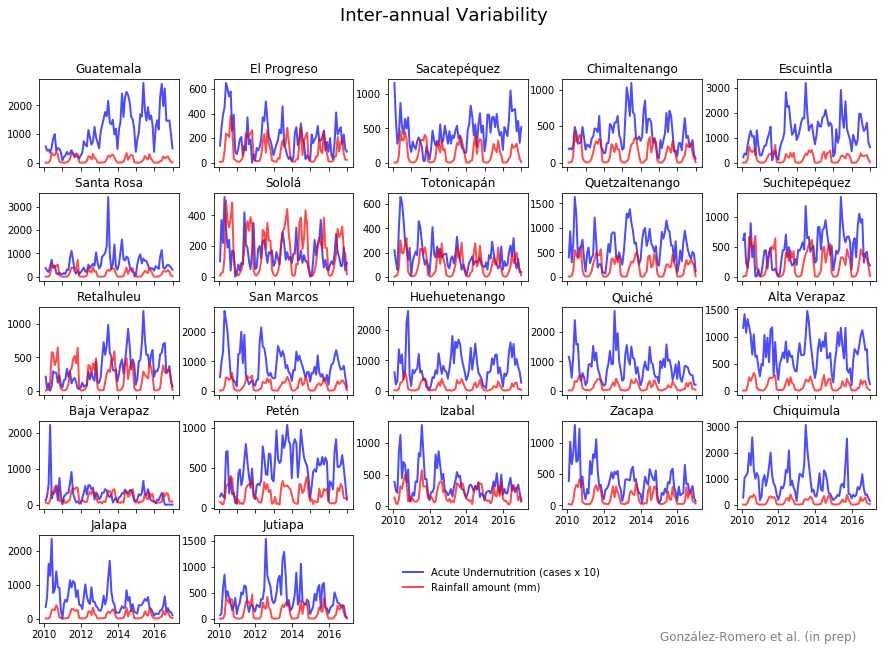

In [23]:
rcParams['figure.figsize'] = 15, 10 #width, height
fig, axs = plt.subplots(5,5,gridspec_kw={'hspace': 0.3, 'wspace': 0.25})
axs = axs.flatten()
fig.suptitle('Inter-annual Variability', fontsize=18)
rcParams.update({'font.size': 10})
for i in range(0,22):
    axs[i].plot(undernut.index,10*undernut[undernut.columns[i]],'b',rain.index,rain[rain.columns[i]],'r',linewidth=2, alpha=0.7)
    axs[i].set_title(climoundernut.columns[i])
    axs[i].tick_params(bottom=True, labelbottom=False)
    #axs[i].fill_between(climoundernut.index, 10*(climoundernut[climoundernut.columns[i]]-stdundernut[stdundernut.columns[i]]), 10*(climoundernut[climoundernut.columns[i]]+stdundernut[stdundernut.columns[i]]),color='b',alpha=0.2)
    #axs[i].fill_between(climorain.index, (climorain[climorain.columns[i]]-stdrain[stdrain.columns[i]]), (climorain[climorain.columns[i]]+stdrain[stdrain.columns[i]]),color='r',alpha=0.2)
    if i>=17:
        #axs[i].set_xticklabels(ticks)
        axs[i].set_xticks(axs[i].get_xticks()[::2]) #show ticks every 2 years
        axs[i].tick_params(bottom=True, labelbottom=True)
fig.delaxes(axs[22])
fig.delaxes(axs[23])
fig.delaxes(axs[24])
handles, labels = axs[21].get_legend_handles_labels()
fig.legend(handles, ['Acute Undernutrition (cases x 10)','Rainfall amount (mm)'], loc = (0.45, 0.09),frameon=False)
fig.text(0.7, 0.1, "González-Romero et al. (in prep)", size=12, color='gray')
plt.savefig("rainfall_undernut_interannual.pdf")

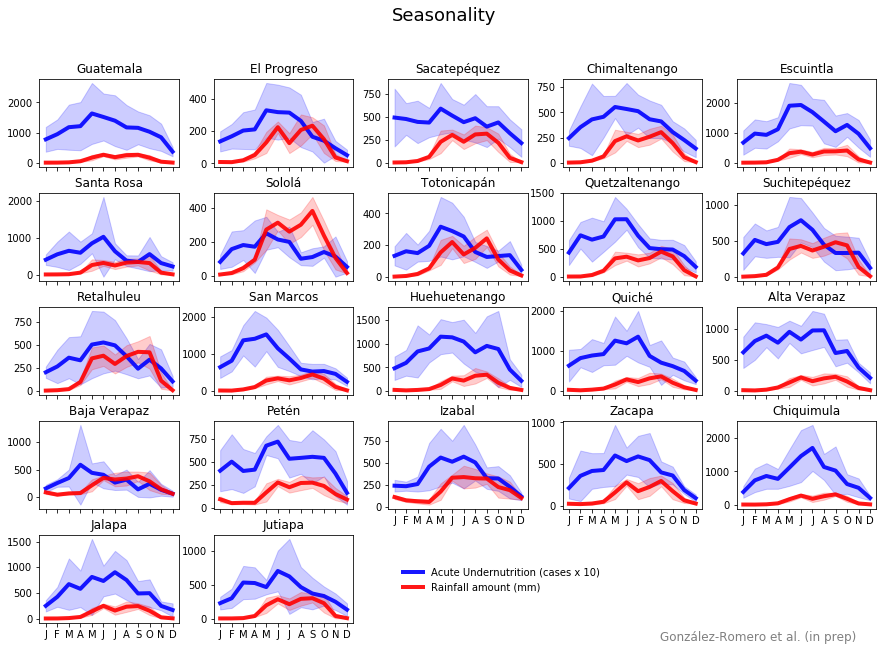

In [22]:
fig, axs = plt.subplots(5,5,gridspec_kw={'hspace': 0.3, 'wspace': 0.25})
axs = axs.flatten()
fig.suptitle('Seasonality', fontsize=18)
rcParams.update({'font.size': 10})
ticks=('J', 'F', 'M', 'A', 'M','J','J','A','S','O','N','D')
for i in range(0,22):
    axs[i].plot(climoundernut.index,10*climoundernut[climoundernut.columns[i]],'b',climorain.index,climorain[climorain.columns[i]],'r',linewidth=4, alpha=0.9)
    axs[i].set_title(climoundernut.columns[i])
    axs[i].tick_params(bottom=True, labelbottom=False)
    axs[i].fill_between(climoundernut.index, 10*(climoundernut[climoundernut.columns[i]]-stdundernut[stdundernut.columns[i]]), 10*(climoundernut[climoundernut.columns[i]]+stdundernut[stdundernut.columns[i]]),color='b',alpha=0.2)
    axs[i].fill_between(climorain.index, (climorain[climorain.columns[i]]-stdrain[stdrain.columns[i]]), (climorain[climorain.columns[i]]+stdrain[stdrain.columns[i]]),color='r',alpha=0.2)
    if i>=17:
        axs[i].set_xticklabels(ticks)
        axs[i].tick_params(bottom=True, labelbottom=True)
fig.delaxes(axs[22])
fig.delaxes(axs[23])
fig.delaxes(axs[24])
handles, labels = axs[21].get_legend_handles_labels()
fig.legend(handles, ['Acute Undernutrition (cases x 10)','Rainfall amount (mm)'], loc = (0.45, 0.09),frameon=False)
fig.text(0.7, 0.1, "González-Romero et al. (in prep)", size=12, color='gray')
plt.savefig("rainfall_undernut_clim.pdf")

## Compute Cross-Correlation Functions to identify lags

In [19]:
def crosscorr(datax, datay, lag=0,method='spearman'):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

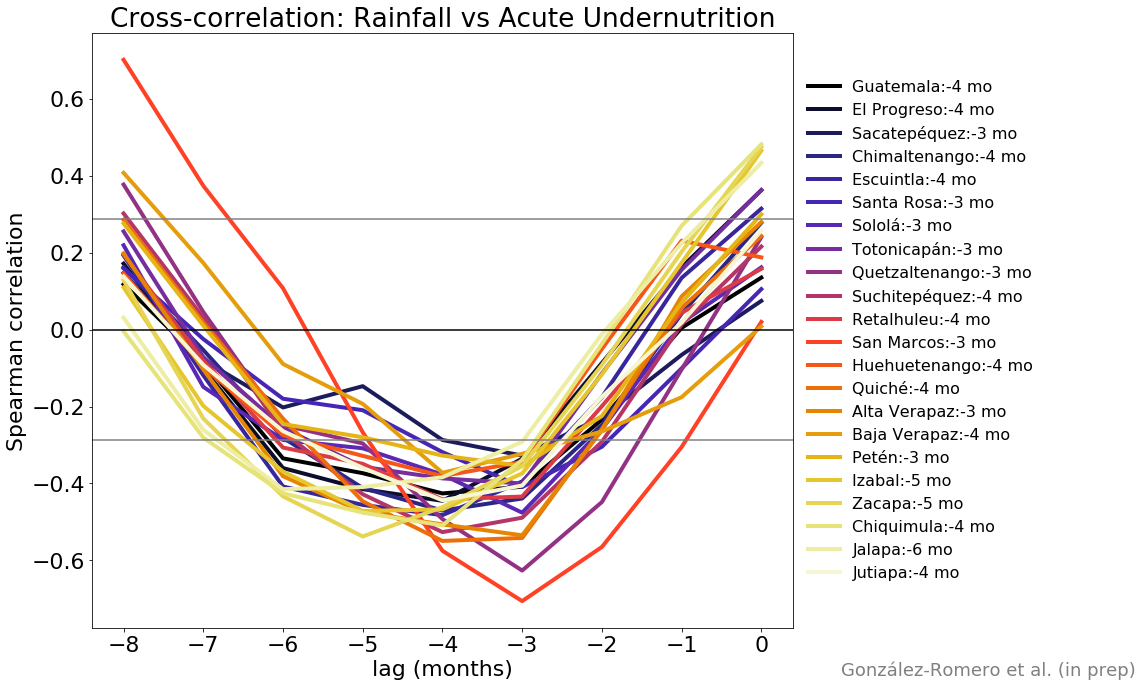

In [20]:
tmin,tmax = -8,1 #min and max lags to explore and plot
sigthreshold=2.58/(np.sqrt(84-3)) #2.58/sqrt(degoffreedom-3)

cmap = plt.cm.CMRmap #see colormap selection here: https://matplotlib.org/1.4.1/users/colormaps.html
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, 23))) #22 departments (and lines in the plot)
rcParams['figure.figsize'] = 15, 10 #width, height
rcParams.update({'font.size': 22})
rcParams['axes.facecolor'] = 'white'
style = dict(size=18, color='gray')

max_x=[]
leyenda=[]
for fi in range(0,22): 
    xcov_monthly = [crosscorr(rain[rain.columns[fi]], undernut[undernut.columns[fi]], lag=i) for i in range(tmin,tmax)]
    plt.plot(range(tmin,tmax),xcov_monthly,lw=4)
    if min(xcov_monthly)<=-sigthreshold:
        max_corr = min(xcov_monthly)  # Find the maximum y value
        max_x.append(range(tmin,tmax)[xcov_monthly.index(max_corr)])  # Find the x value corresponding to the maximum y value
    else:
        max_x.append(np.nan)
    leyenda.append(appended_data.columns[fi]+":"+str(max_x[fi])+" mo")
    #print(leyenda[fi])

plt.axhline(y=0,color='k')
plt.axhline(y=sigthreshold,color='gray')
plt.axhline(y=-sigthreshold,color='gray') 
plt.title('Cross-correlation: Rainfall vs Acute Undernutrition')
plt.xlabel('lag (months)')
plt.ylabel('Spearman correlation')
plt.legend(leyenda,frameon=False,loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 16})
plt.tight_layout()
plt.text(1, -0.9, "González-Romero et al. (in prep)", **style)
plt.savefig("rainfall_undernut_lags.pdf")

## Write data to file

In [157]:
undernut.to_excel("almostCPTformat2.xlsx")

In [ ]:
# xmlns:cpt=http://iri.columbia.edu/CPT/v10/																						
# cpt:field=undernutage5, cpt:nrow=364, cpt:ncol=22, cpt:row=T, cpt:col=station, cpt:units=cases, cpt:missing=-999																						
# cpt:X	-90.60	-90.10	-90.80	-90.90	-91.00	-90.40	-91.25	-91.40	-91.60	-91.40	-91.80	-91.80	-91.50	-91.00	-90.20	-90.40	-90.00	-89.20	-89.50	-89.40	-90.00	-90.00
# cpt:Y	14.60	14.80	14.50	14.70	14.10	14.20	14.70	15.00	14.80	14.40	14.40	15.00	15.60	15.40	15.60	15.00	17.00	15.50	15.00	14.60	14.70	14.30